# CLASSIFICADOR DE PREUS DE MÒBIL

## INTRODUCCIÓ

Aquest notebook executarem els mateixos models però ara tenint en compte les correlacions i fent un treshold, a la conclusió compararem quin dels dos es millor opció.
Per tant obviarem l'exploració i l'analisis i anirem directament a la creació de models.

## BIBLIOTEQUES I DEPENDÈNCIES

Utilitzarem les mateixes biblioteques que a l'anterior notebook.

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import numpy as np

from plotly.offline import iplot
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report,accuracy_score, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing

Cridem al fitxer on hem tenim les funcions que utilitzarem externes a les biblioteques cridades anteriorment.

In [2]:
%run FuncionsUtilitzades.ipynb

In [3]:
dataset = load_dataset('./train.csv')

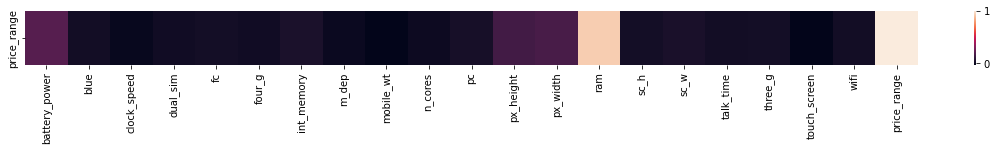

In [4]:
price_correlation = dataset.corr()['price_range'].to_frame().T 
plt.subplots(figsize=(20, 1))
sns.heatmap(price_correlation)
plt.show()

Tallarem el notre dataset amb un treshold de 0.15, per tenir 3 atributs.

In [5]:
correlation_threshold = 0.15

attributes = list(filter(lambda lbda: abs(float(price_correlation[lbda])) > correlation_threshold, dataset.columns))

print('Atributs després de fer el tall:', len(attributes))
print('Que serien :',", ".join(attributes))

Atributs després de fer el tall: 4
Que serien : battery_power, px_width, ram, price_range


Com es pot veure treballarem amb els següents atributs:
- **battery_power**
- **px_width**
- **ram**

In [6]:
dataset= dataset[attributes]

In [7]:
X = dataset.drop(labels=['price_range'], axis=1)
y = dataset['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,test_size=0.2, random_state = 30)

## CREACIÓ DELS MODELS

Per a que les figures siguin totalment visibles definim els següents paràmetres per default.

In [8]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

### Regressió Logística

In [9]:
from sklearn.linear_model import LogisticRegression

Entrenem el model.

In [10]:
lre = LogisticRegression(multi_class='ovr', solver='liblinear')

lre.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [11]:
pred_lre = lre.predict(X_test)
print(classification_report(y_test, pred_lre))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91        99
           1       0.79      0.57      0.66        97
           2       0.66      0.57      0.61        88
           3       0.83      0.99      0.90       116

    accuracy                           0.79       400
   macro avg       0.78      0.78      0.77       400
weighted avg       0.78      0.79      0.78       400



In [12]:
accuracy_lre = round(accuracy_score(y_test, pred_lre)*100, 2)

print('Accuracy:', accuracy_lre, '%')

Accuracy: 79.25 %


Comparem amb l'accuracy que ens dona l'anterior preprocessat i veiem que l'accuracy ens donaba **78,5%**, la resta de metriques són semblant. Per tant determinem que aquest model es una miqueta millor per al dataset amb treshold.

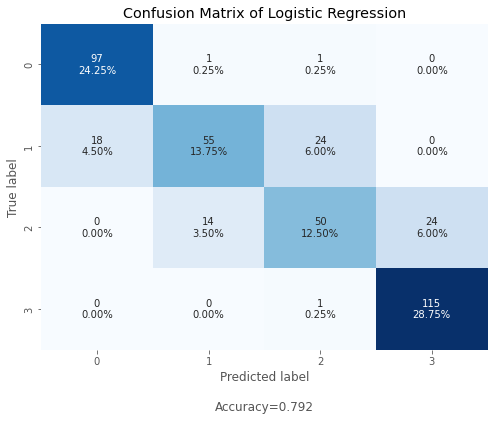

In [13]:
cf_matrix_lre = confusion_matrix(y_test, pred_lre)
make_confusion_matrix(cf_matrix_lre, figsize=(8,6), cbar=False, title='Confusion Matrix of Logistic Regression')

Les confusion matrics son gairebe identiques.

In [14]:
proba_lre = lre.predict_proba(X_test)

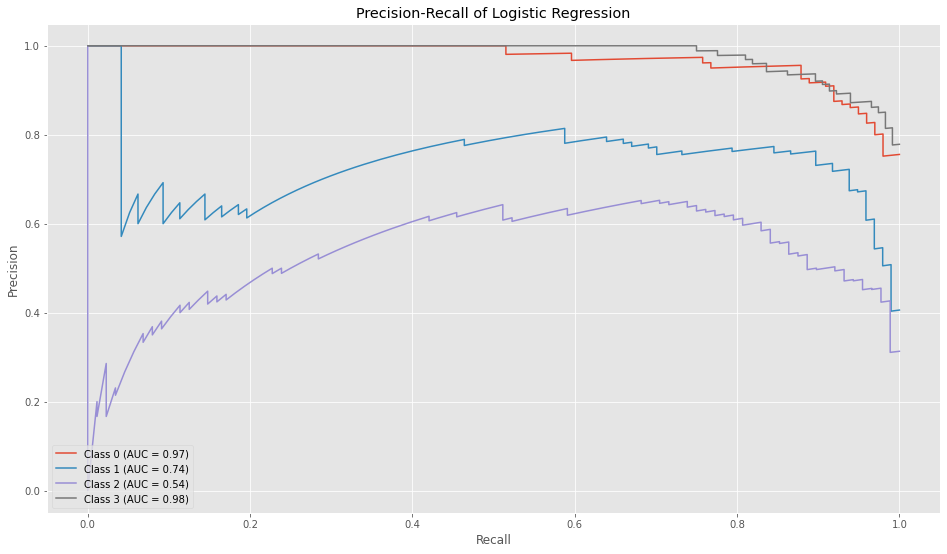

In [15]:
precision_lre = {}
recall_lre= {}
average_precision_lre = {}
make_curvaP_R(precision_lre, recall_lre, average_precision_lre, proba_lre, 'Precision-Recall of Logistic Regression') 

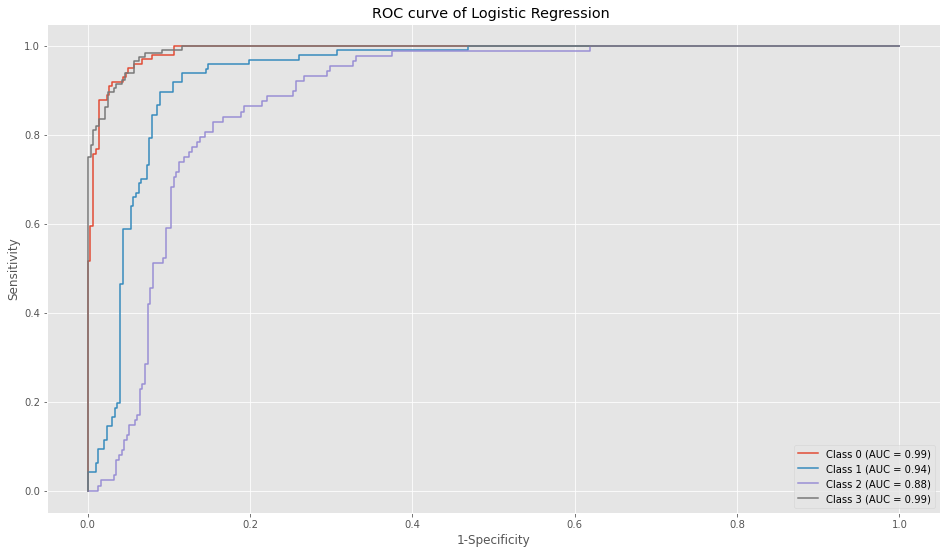

In [16]:
fpr_lre = {}
tpr_lre = {}
roc_auc_lre = {}
make_curva_ROC(fpr_lre, tpr_lre, roc_auc_lre, proba_lre, 'ROC curve of Logistic Regression ')

Les figures de les  corves també són molt paregudes, hi ha canvis minims. L'únic destacable seria a la corva Precision-Recall, la precision es 0 quan el recall és 0 a la classe 2.

### KNN

In [17]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

([<matplotlib.axis.XTick at 0x1d0d8ea64f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

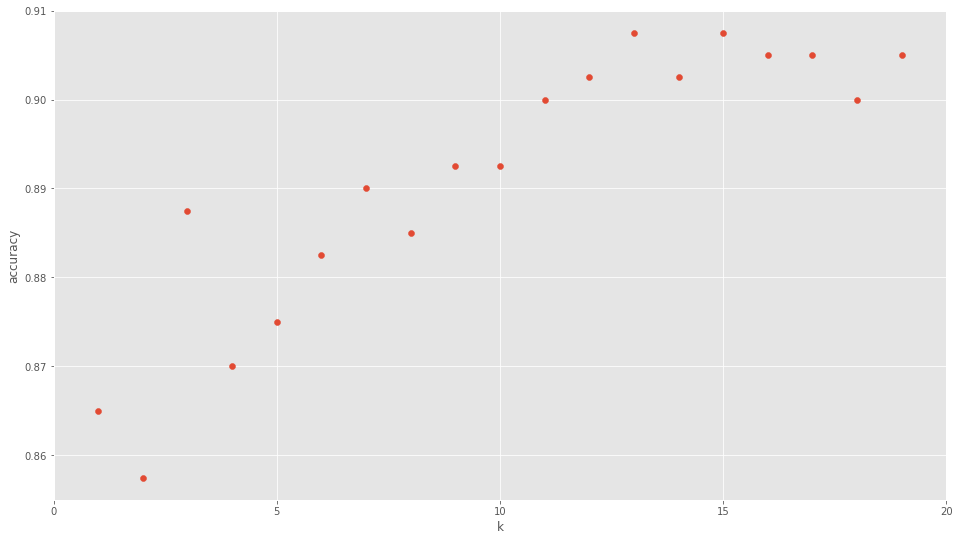

In [18]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

Veiem que a diferencia de la K optima de l'altre proprocessing que era 9, aquest cas pot sera tant 15 com 13.  

Per tant per a l'entrenament utilitzarem una K=15.

In [19]:
n_neighbors = 15

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [20]:
pred_knn = knn.predict(X_test)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        99
           1       0.91      0.89      0.90        97
           2       0.81      0.88      0.84        88
           3       0.95      0.89      0.92       116

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



Podem apreciar que totes lés métriques són molt altes, amb una precision mínima d'un 86%, per ara és el model que faria millor la classificació.

In [21]:
accuracy_knn = round(accuracy_score(y_test, pred_knn)*100, 2)

print('Accuracy:', accuracy_knn, '%')

Accuracy: 90.75 %


A aquest model passa al contrari que l'anterior, l'accuracy disminueix, mentres que a l'altre preprocessat era de 93.5%, amb el nostre treshold només tenim 90.75%, que segueix sent bastant alt.

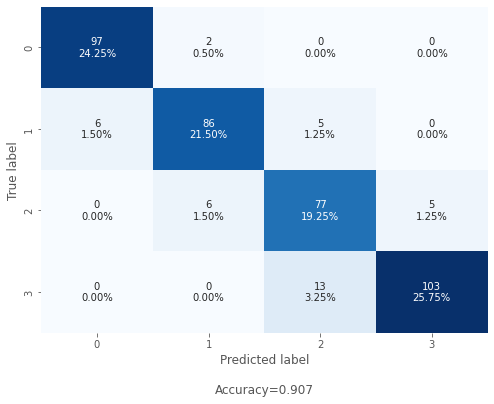

In [22]:
cf_matrix_knn = confusion_matrix(y_test, pred_knn)
make_confusion_matrix(cf_matrix_knn, figsize=(8,6), cbar=False)

In [23]:
proba_knn = knn.predict_proba(X_test)

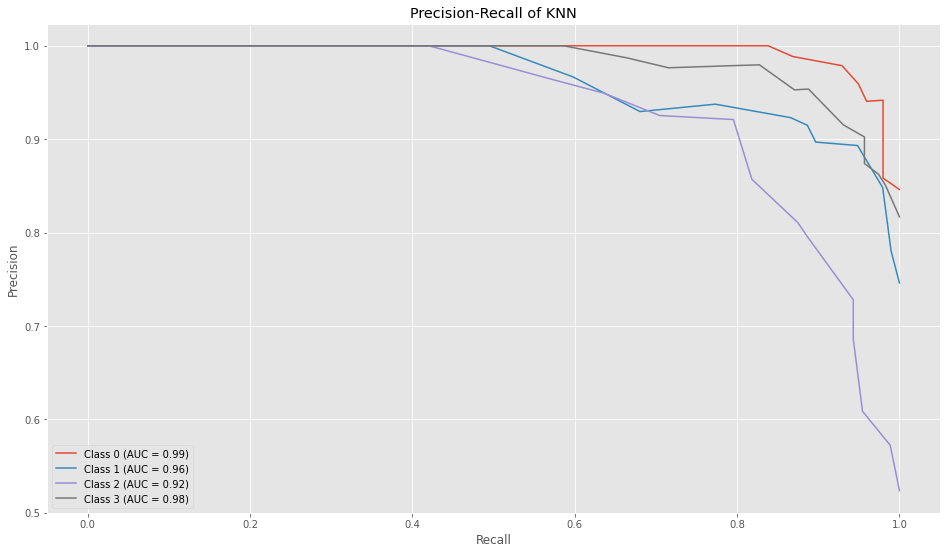

In [24]:
precision_knn = {}
recall_knn = {}
average_precision_knn = {}
make_curvaP_R(precision_knn, recall_knn, average_precision_knn, proba_knn, 'Precision-Recall of KNN')

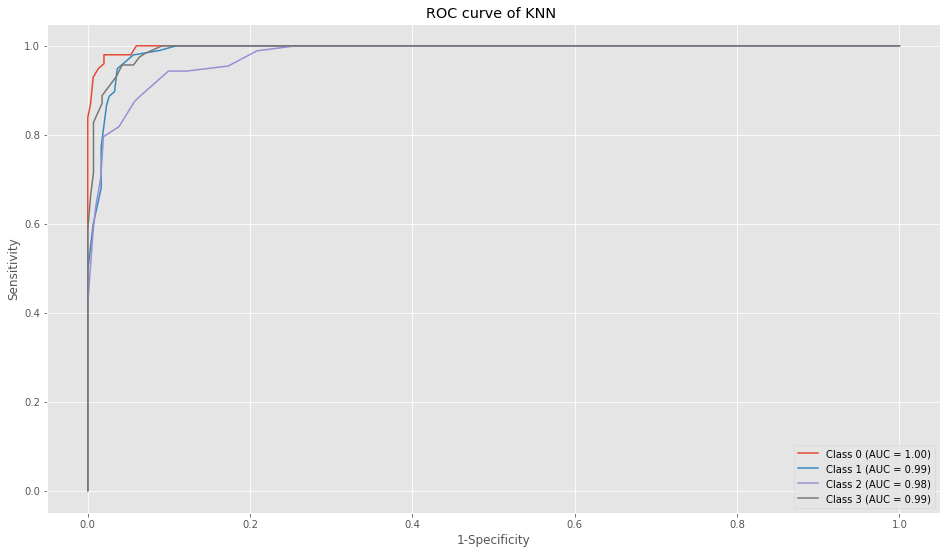

In [25]:
fpr_knn = {}
tpr_knn = {}
roc_auc_knn = {}
make_curva_ROC(fpr_knn, tpr_knn, roc_auc_knn, proba_knn, 'ROC curve of KNN ')

Els métodes d'evaluació, es adir la confusion matrix, les corves Precision-recall i ROC, són molt paregudes a les de l'altre preprocessat, l'únic canvi destacable es a la taula Precision-Recall, la classe 2, baixa molt més quan ens apropem a 1 del recall.

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [28]:
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        99
           1       0.87      0.85      0.86        97
           2       0.79      0.83      0.81        88
           3       0.93      0.88      0.90       116

    accuracy                           0.88       400
   macro avg       0.87      0.88      0.87       400
weighted avg       0.88      0.88      0.88       400



In [29]:
accuracy_rf = round(accuracy_score(y_test, pred_rf)*100, 2)

print('Accuracy:', accuracy_rf, '%')

Accuracy: 87.75 %


L'accuracy es més alt amb el nostre treshold, exactament un 2% millor, les altres són molt semblants, hi ha petits canvis.

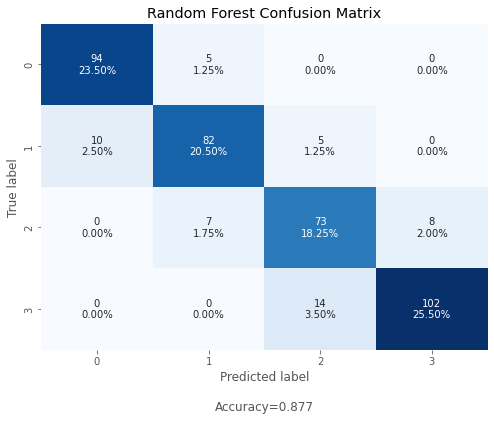

In [30]:
cf_matrix_rf = confusion_matrix(y_test, pred_rf)

make_confusion_matrix(cf_matrix_rf, figsize=(8,6), cbar=False, title='Random Forest Confusion Matrix')

In [31]:
proba_rf = rf.predict_proba(X_test)

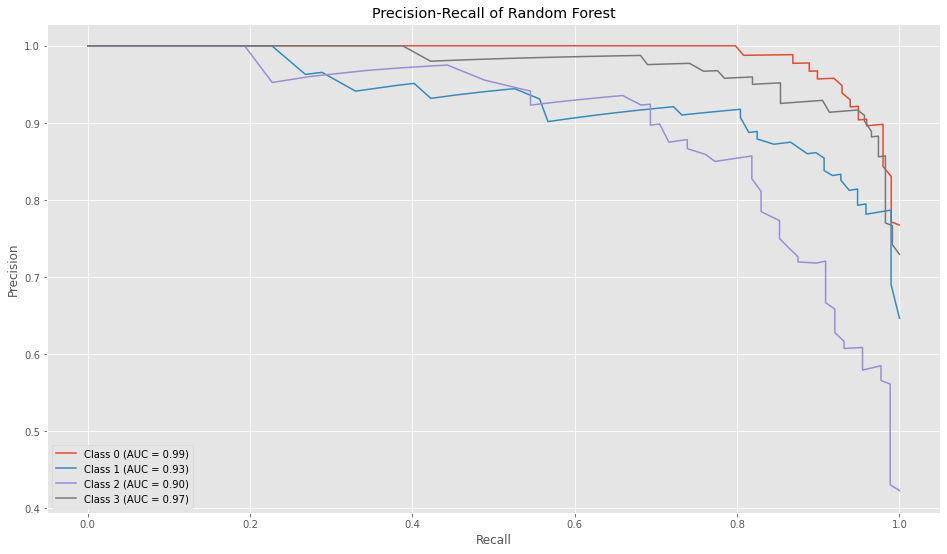

In [32]:
precision_rf = {}
recall_rf = {}
average_precision_rf = {}
make_curvaP_R(precision_rf, recall_rf, average_precision_rf, proba_rf, 'Precision-Recall of Random Forest') 

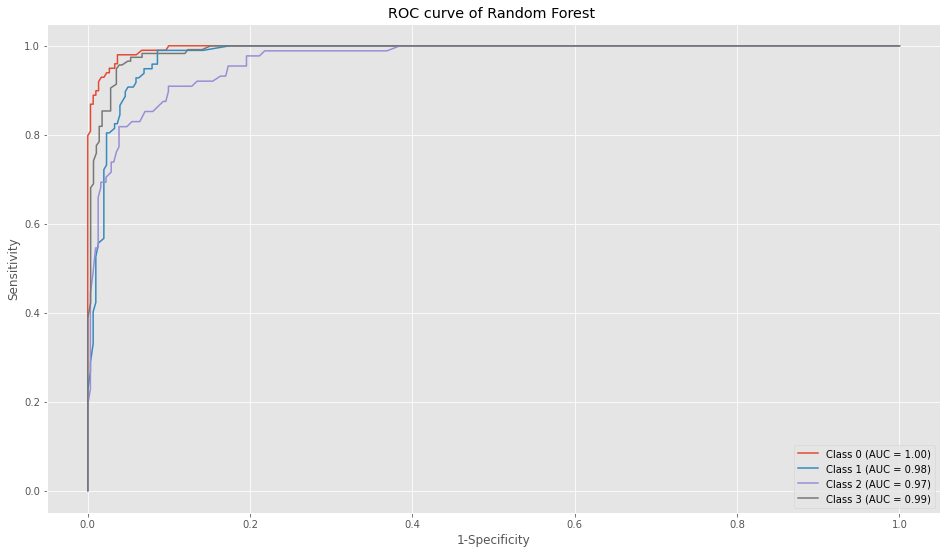

In [33]:
fpr_rf = {}
tpr_rf = {}
roc_auc_rf = {}
make_curva_ROC(fpr_rf, tpr_rf, roc_auc_rf, proba_rf, 'ROC curve of Random Forest ')

En aquest cas l'AUC és una mica millor a les 2 corves amb el nostre treshold, però no hi ha alguna activitat d'alguna classe que destaqui, són molt paregudes.

### SVM-Multiclass

In [34]:
from sklearn import svm

Igual que a l'latre notebook probarem amb tots els kernels.

In [35]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo',probability=True)
linear = linear.fit(X_train, y_train)

In [36]:
linear_pred = linear.predict(X_test)
print(classification_report(y_test, linear_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.93      0.87      0.90        97
           2       0.85      0.89      0.87        88
           3       0.95      0.92      0.93       116

    accuracy                           0.92       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.92      0.92      0.91       400



In [37]:
accuracy_linear = round(accuracy_score(y_test, linear_pred)*100, 2)
print('Accuracy:', accuracy_linear, '%')

Accuracy: 91.5 %


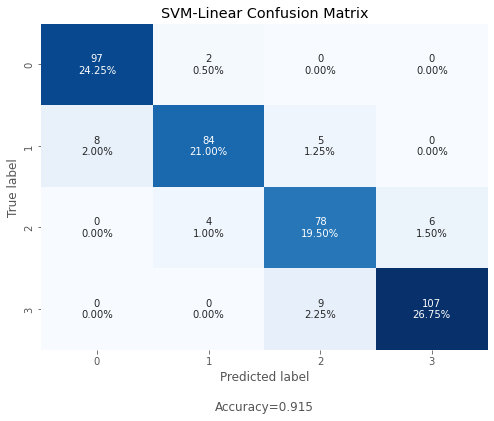

In [38]:
cf_matrix_svm_li = confusion_matrix(y_test, linear_pred)
make_confusion_matrix(cf_matrix_svm_li, figsize=(8,6), cbar=False, title='SVM-Linear Confusion Matrix')

In [39]:
proba_svm_line = linear.predict_proba(X_test)

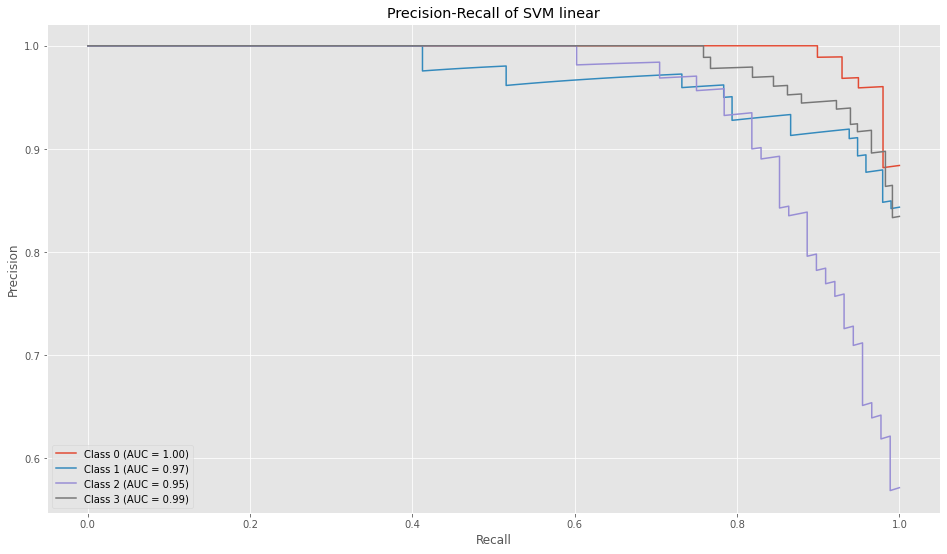

In [40]:
precision_line = {}
recall_line= {}
average_precision_line = {}
make_curvaP_R(precision_line, recall_line, average_precision_line, proba_svm_line, 'Precision-Recall of SVM linear')  

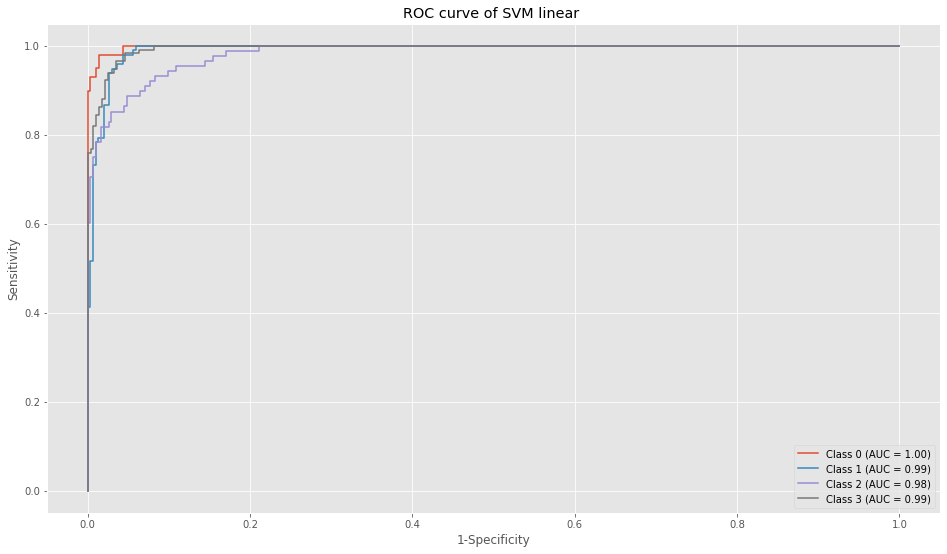

In [41]:
fpr_line = {}
tpr_line = {}
roc_auc_line = {}
make_curva_ROC(fpr_line, tpr_line, roc_auc_line, proba_svm_line, 'ROC curve of SVM linear ')

In [42]:
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo',probability=True)
poly = poly.fit(X_train, y_train)

In [43]:
poly_pred = poly.predict(X_test, )
print(classification_report(y_test, poly_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.91      0.85      0.88        97
           2       0.81      0.86      0.84        88
           3       0.95      0.91      0.93       116

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



In [44]:
accuracy_poly = round(accuracy_score(y_test, poly_pred)*100, 2)
print('Accuracy:', accuracy_poly, '%')

Accuracy: 90.0 %


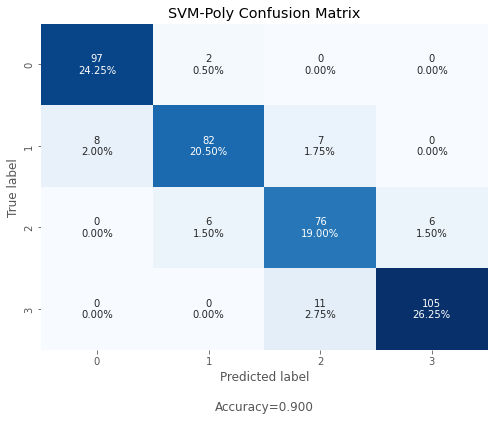

In [45]:
cf_matrix_svm_poly = confusion_matrix(y_test, poly_pred)

make_confusion_matrix(cf_matrix_svm_poly, figsize=(8,6), cbar=False, title='SVM-Poly Confusion Matrix')

In [46]:
proba_svm_poly = poly.predict_proba(X_test)

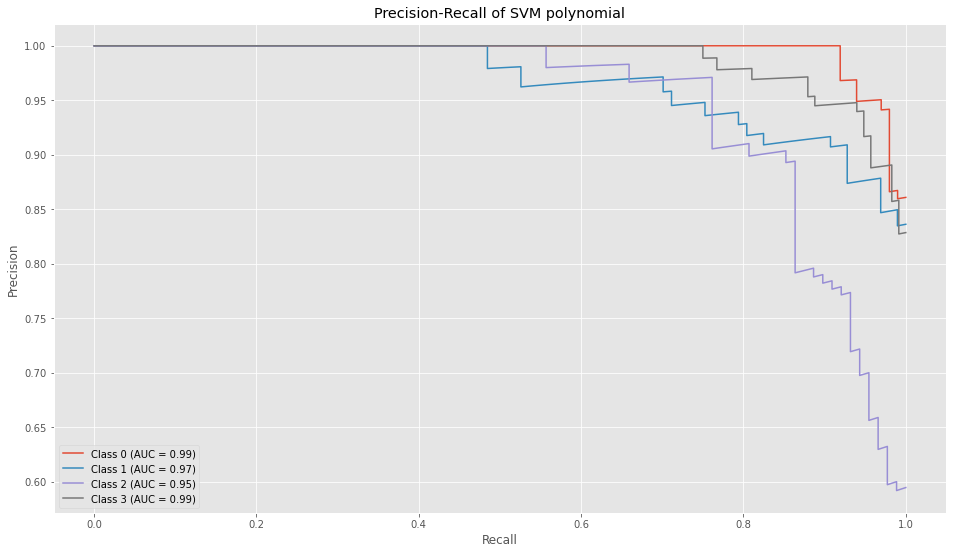

In [47]:
precision_poly = {}
recall_poly= {}
average_precision_poly = {}
make_curvaP_R(precision_poly, recall_poly, average_precision_poly, proba_svm_poly, 'Precision-Recall of SVM polynomial')  

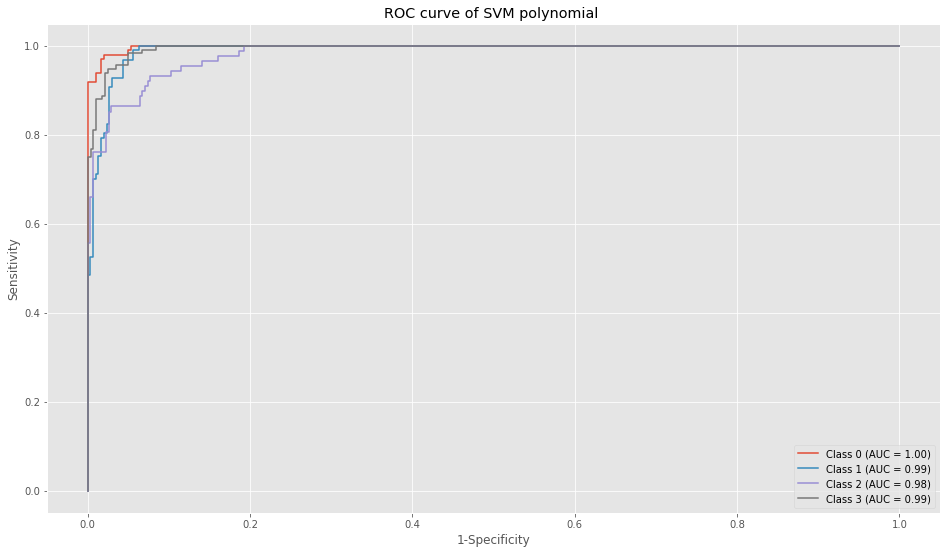

In [48]:
fpr_poly = {}
tpr_poly = {}
roc_auc_poly = {}
make_curva_ROC(fpr_poly, tpr_poly, roc_auc_poly, proba_svm_poly, 'ROC curve of SVM polynomial ')

In [49]:
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo',probability=True)
rbf = rbf.fit(X_train, y_train)

In [50]:
rbf_pred = rbf.predict(X_test)
print(classification_report(y_test, rbf_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.00      0.00      0.00        97
           2       0.22      1.00      0.36        88
           3       0.00      0.00      0.00       116

    accuracy                           0.22       400
   macro avg       0.06      0.25      0.09       400
weighted avg       0.05      0.22      0.08       400



In [51]:
accuracy_rbf = round(accuracy_score(y_test, rbf_pred)*100, 2)
print('Accuracy:', accuracy_rbf, '%')

Accuracy: 22.0 %


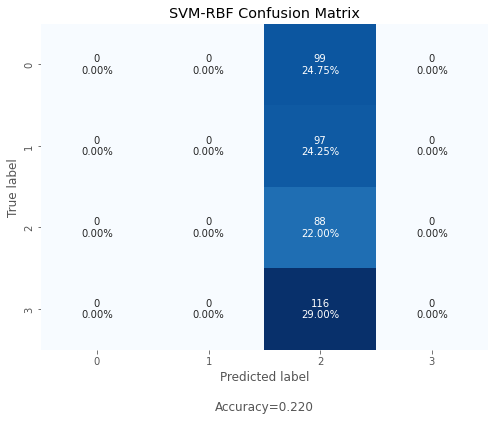

In [52]:
cf_matrix_svm_rbf = confusion_matrix(y_test, rbf_pred)

make_confusion_matrix(cf_matrix_svm_rbf, figsize=(8,6), cbar=False, title='SVM-RBF Confusion Matrix')

In [53]:
proba_svm_rbf = rbf.predict_proba(X_test)

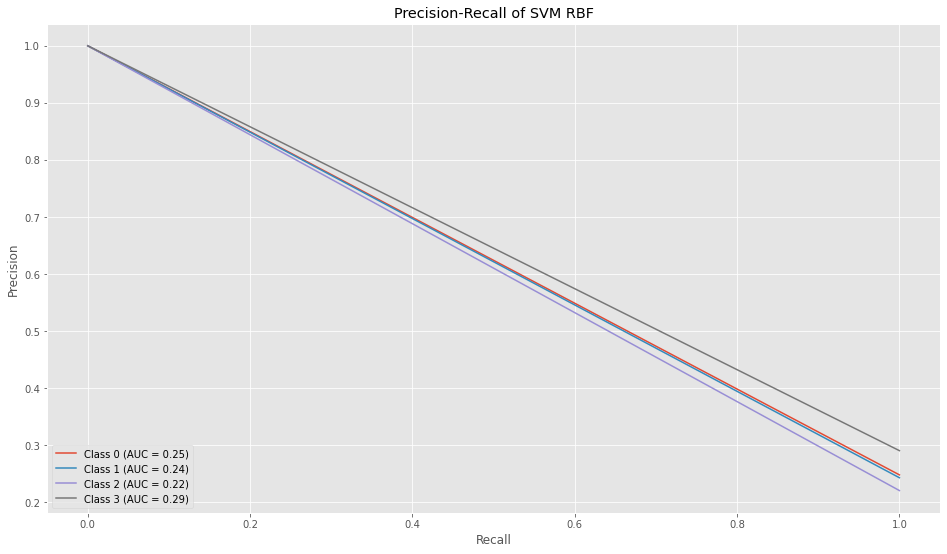

In [54]:
precision_rbf = {}
recall_rbf= {}
average_precision_rbf = {}
make_curvaP_R(precision_rbf, recall_rbf, average_precision_rbf, proba_svm_rbf, 'Precision-Recall of SVM RBF')  

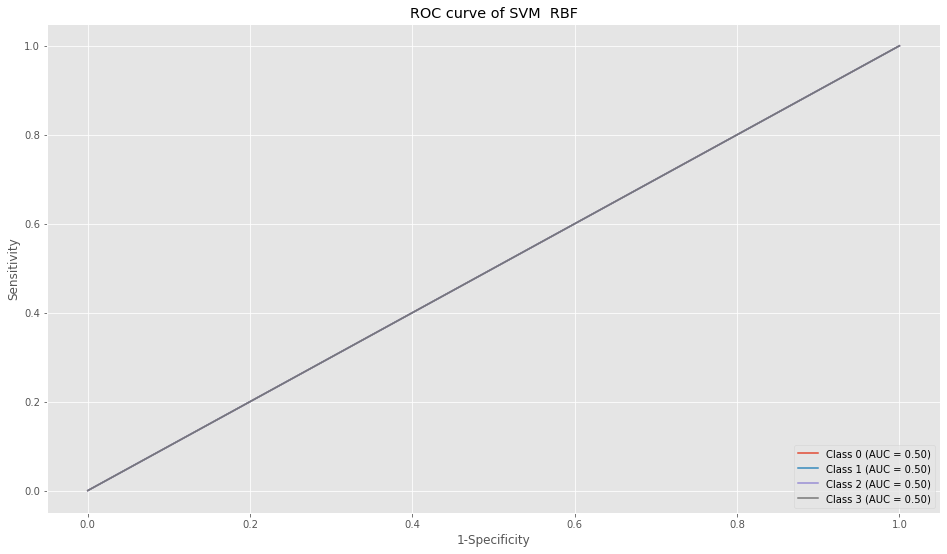

In [55]:
fpr_rbf = {}
tpr_rbf = {}
roc_auc_rbf = {}
make_curva_ROC(fpr_rbf, tpr_rbf, roc_auc_rbf, proba_svm_rbf, 'ROC curve of SVM  RBF')

In [56]:
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo',probability=True)
sig = sig.fit(X_train, y_train)

In [57]:
sig_pred = sig.predict(X_test)
print(classification_report(y_test, sig_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.01      0.03      0.02        99
           1       0.00      0.00      0.00        97
           2       0.19      0.09      0.12        88
           3       0.00      0.00      0.00       116

    accuracy                           0.03       400
   macro avg       0.05      0.03      0.04       400
weighted avg       0.05      0.03      0.03       400



In [58]:
accuracy_sig = round(accuracy_score(y_test, sig_pred)*100, 2)
print('Accuracy:', accuracy_sig, '%')

Accuracy: 2.75 %


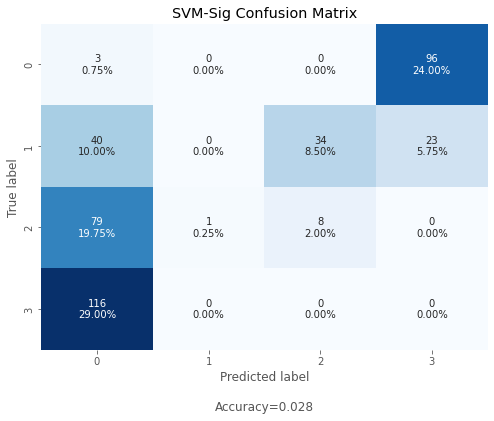

In [59]:
cf_matrix_svm_sig = confusion_matrix(y_test, sig_pred)

make_confusion_matrix(cf_matrix_svm_sig, figsize=(8,6), cbar=False, title='SVM-Sig Confusion Matrix')

In [60]:
proba_svm_sig = sig.predict_proba(X_test)

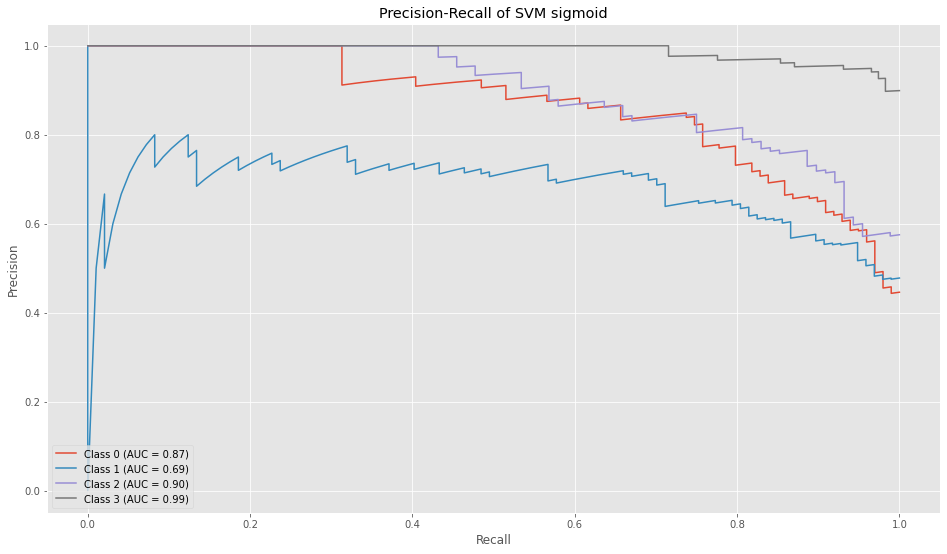

In [61]:
precision_sig = {}
recall_sig= {}
average_precision_sig = {}
make_curvaP_R(precision_sig, recall_sig, average_precision_sig, proba_svm_sig, 'Precision-Recall of SVM sigmoid')  

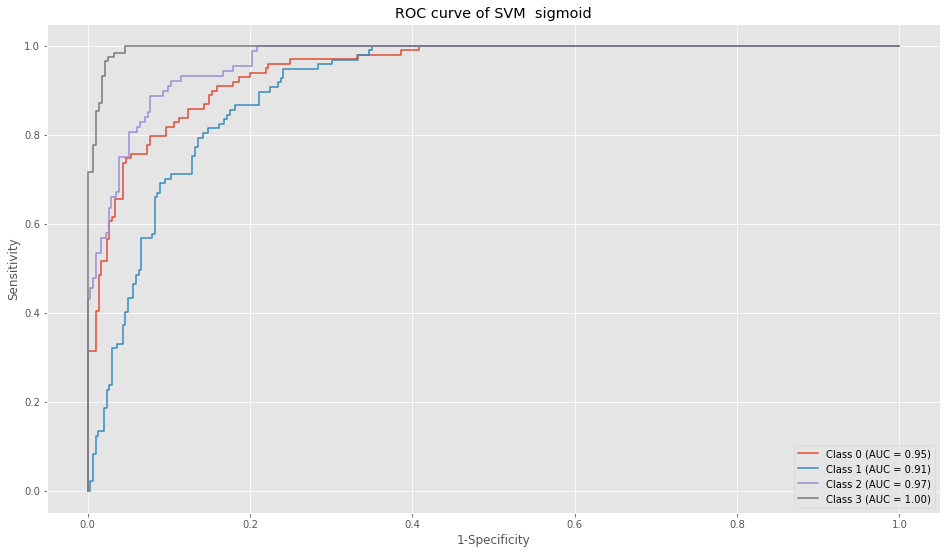

In [62]:
fpr_sig = {}
tpr_sig = {}
roc_auc_sig = {}
make_curva_ROC(fpr_sig, tpr_sig, roc_auc_sig, proba_svm_sig, 'ROC curve of SVM  sigmoid')

El kernel linear segueix sent el millor per a la nostre classificació però es més baix que amb l'altre preprocessat, passa el mateix amb el kernel polinomial.
Però amb el kernel RBF l'accuracy dona el mateix 22.5%, i per últim el kernel sigmoid és molt dolent , ens dona menys d'un 3% d'accuracy.
Per tant, determinem que l'altre preprocessat treballa millor amb el SVM, però aquest model segueix sent el millor per classificar el nostre data frame.

### Arbres de decisió

In [63]:
import sklearn.tree as tree

from sklearn.tree import DecisionTreeClassifier

In [64]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [65]:
pred_dtree = dtree.predict(X_test)
print(classification_report(y_test, pred_dtree))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        99
           1       0.83      0.78      0.80        97
           2       0.76      0.81      0.78        88
           3       0.90      0.89      0.89       116

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.85      0.84      0.85       400



In [66]:
accuracy_dtree = round(accuracy_score(y_test, pred_dtree)*100, 2)
print('Accuracy:', accuracy_dtree, '%')

Accuracy: 84.5 %


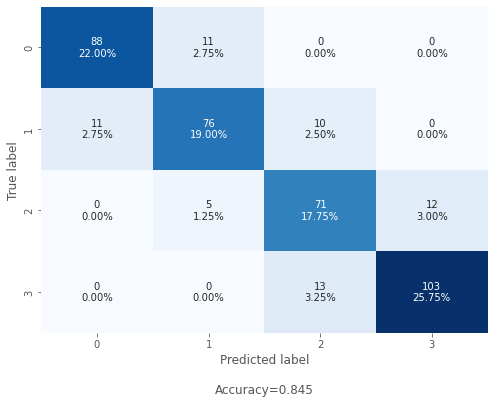

In [67]:
cf_matrix_dtree = confusion_matrix(y_test, pred_dtree)
make_confusion_matrix(cf_matrix_dtree, figsize=(8,6), cbar=False)

In [68]:
proba_dtree = dtree.predict_proba(X_test)

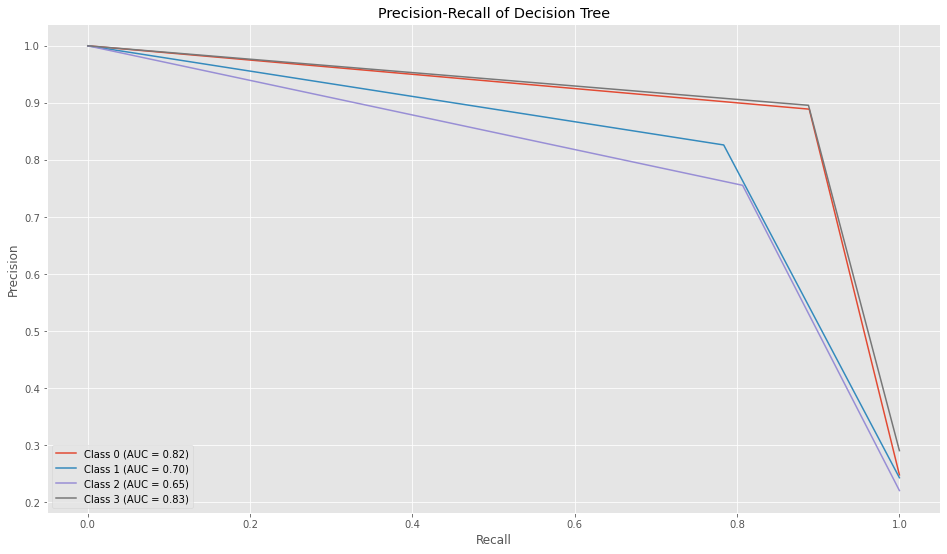

In [69]:
precision_dtree = {}
recall_dtree = {}
average_precision_dtree = {}
make_curvaP_R(precision_dtree, recall_dtree, average_precision_dtree, proba_dtree, 'Precision-Recall of Decision Tree')

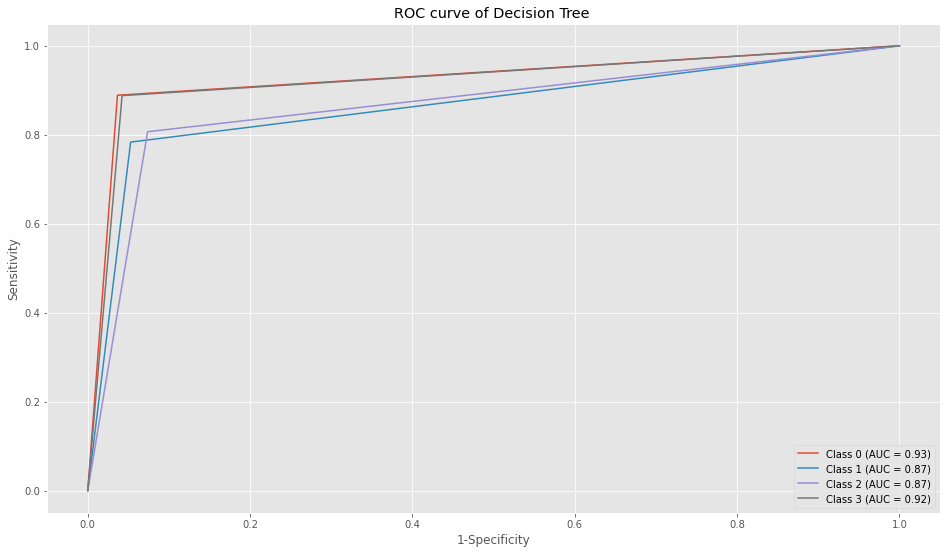

In [70]:
fpr_dtree = {}
tpr_dtree = {}
roc_auc_dtree = {}
make_curva_ROC(fpr_dtree, tpr_dtree, roc_auc_dtree, proba_dtree, 'ROC curve of Decision Tree ')

Visualitzem l'arbre.

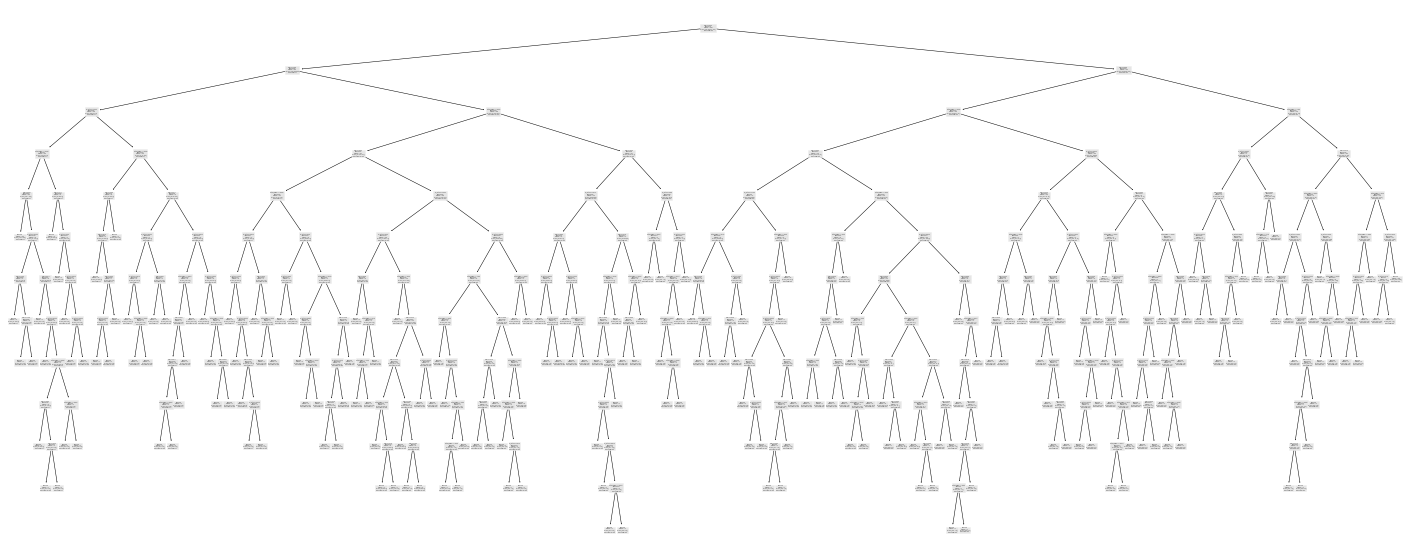

In [71]:
fnames = list(X_train.columns)
cnames = ['low cost', 'medium cost','high cost','very high']

fig, axes = plt.subplots(figsize=(25, 10))
tree.plot_tree(dtree, feature_names=fnames, class_names=cnames)
plt.show()

Com es molt gran només veurem els dos primers pasos.

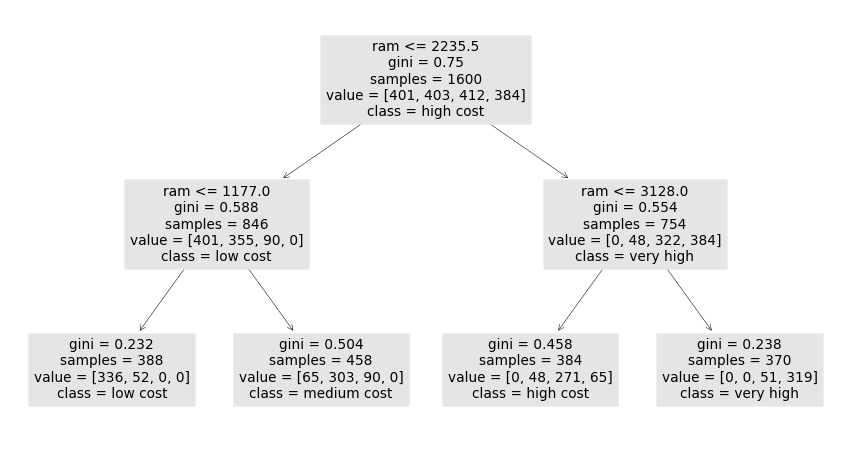

In [72]:
mostra_dtree = DecisionTreeClassifier(max_depth=2)
mostra_dtree = mostra_dtree.fit(X_train, y_train)

fig, axes = plt.subplots(figsize=(15, 8))
tree.plot_tree(mostra_dtree, feature_names=fnames, class_names=cnames)
plt.show()

Ara buscarem els millors hiperparamètres.

In [73]:
pmtrs = dict()
pmtrs['splitter'] = ['best', 'random']
pmtrs['max_depth'] = range(1, len(attributes))
pmtrs['criterion'] = ['gini', 'entropy']

grid_dtree = GridSearchCV(estimator=dtree, param_grid=pmtrs,cv=10)
grid_dtree.fit(X_train, y_train)

print("Best parameters: ", grid_dtree.best_params_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 2, 'splitter': 'best'}


Ara que hem trobat els millors paràmetres, entrenem el nostre arbre amb aquests.

In [74]:
b_pmtrs = grid_dtree.best_params_
b_criterion = b_pmtrs['criterion']
b_depth = b_pmtrs['max_depth']
b_splitter = b_pmtrs['splitter']

dtree_hiper = DecisionTreeClassifier(criterion=b_criterion, max_depth=b_depth, splitter=b_splitter)
dtree_hiper = dtree_hiper.fit(X_train, y_train)

In [75]:
dtree_hiper_pred = dtree_hiper.predict(X_test)

accuracy_hiper_pred = round(accuracy_score(y_test, dtree_hiper_pred)*100, 2)
print('Accuracy:', accuracy_hiper_pred, '%')

Accuracy: 74.25 %


Com podem apreciar l'accuracy s'eleva una mica.

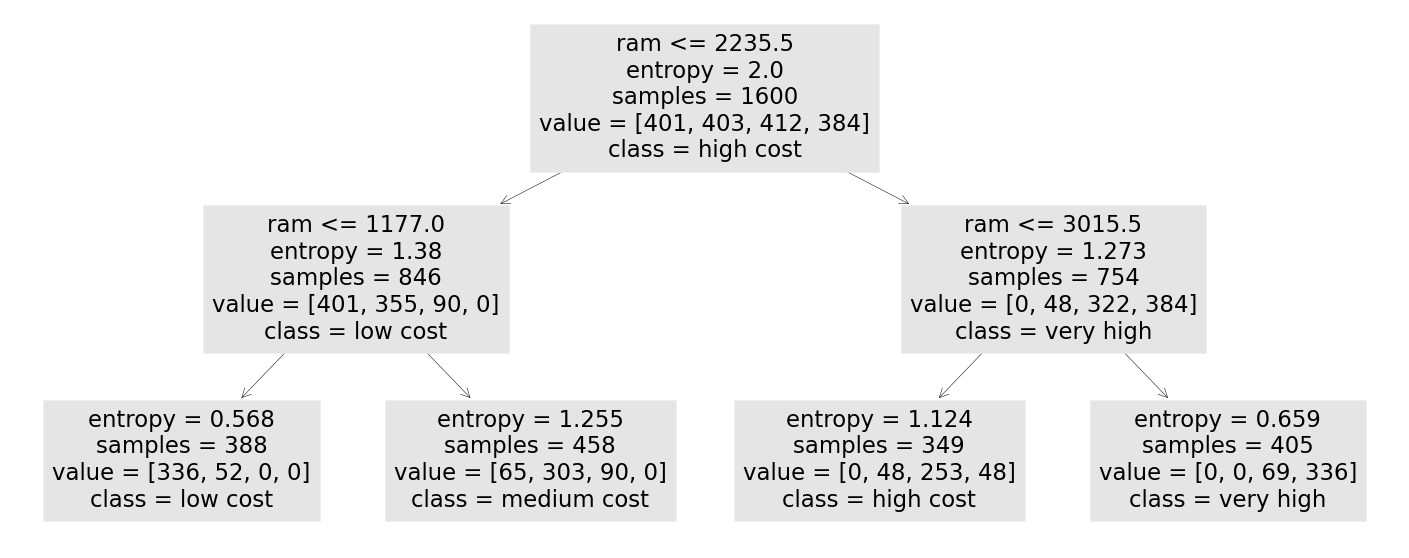

In [76]:
fnames = list(X_train.columns)
cnames = ['low cost', 'medium cost','high cost','very high']

fig, axes = plt.subplots(figsize=(25, 10))
tree.plot_tree(dtree_hiper, feature_names=fnames, class_names=cnames)
plt.show()

L'arbre cambia de forma.

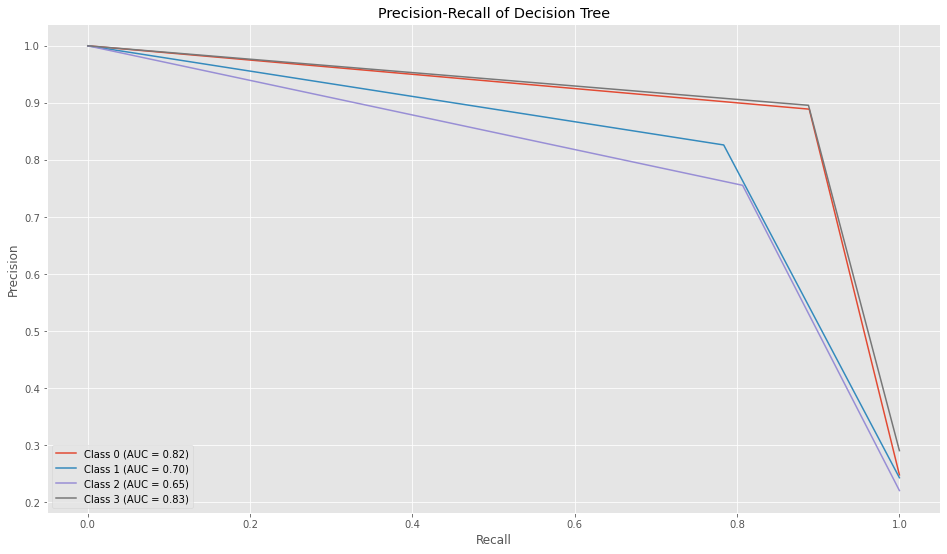

In [77]:
precision_dtree = {}
recall_dtree = {}
average_precision_dtree = {}
make_curvaP_R(precision_dtree, recall_dtree, average_precision_dtree, proba_dtree, 'Precision-Recall of Decision Tree')

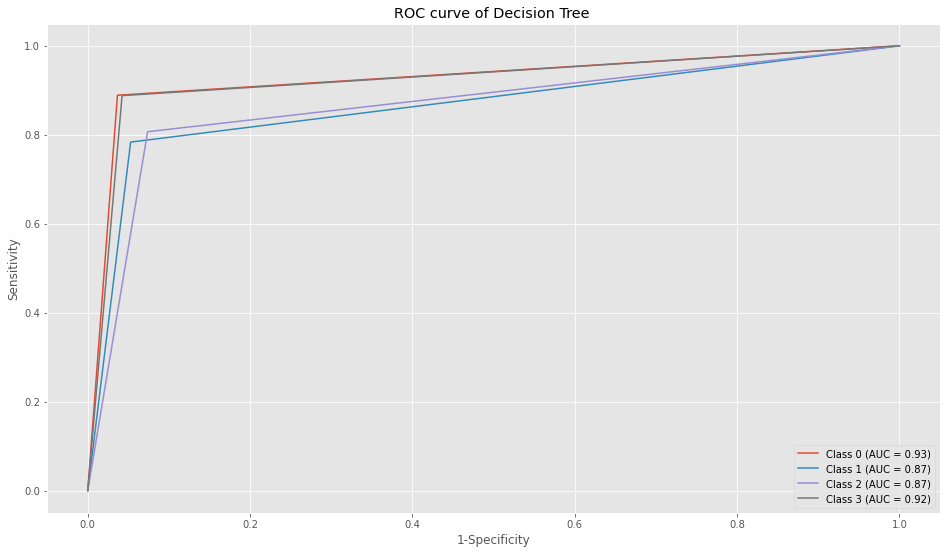

In [78]:
fpr_dtree = {}
tpr_dtree = {}
roc_auc_dtree = {}
make_curva_ROC(fpr_dtree, tpr_dtree, roc_auc_dtree, proba_dtree, 'ROC curve of Decision Tree ')

Com que són tan pocs els atributs que utilitzem per la classificació reduim massa la profunditat i quan busquem els hiperparemetres, fa que el model amb hiperparamètres sigui pitjor que amb els paramètres per defecte.

I en comparació amb preprocessat de l'altre notebook, també és pitjor a l'hora de classificar.

## CONCLUSIONS

Com podem veure creiem que es tracta d'un cas d'underfitting, ja que els atributs amb els que treballem són 3. Tot i aiaxò al tenir una mica de correlació ens donen resultats més bons dels que esperaven.

Un petit resum de totes les comparacions dels models seria aquest:
- **Regressió Logísitca** : En aquest model el dataframe que creem amb el treshold ens dona una millor accuracy , que es de un 79.25 %, mentrés que al model entrenat amb el dataset sencer l'accuracy és de un 78,5%,encara que sigui una millora molt petita determinem que el model és més optim per al dataframe creat en aquest document. També mitjançant la taula de PR podem veure que la precisió és major a les classes on encertem més però a les classes on fem errors es pitjor. 
- **KNN** : Ens esperaven un resultat pitjor a l'accuracy ja que el model tindra massa veins per arrivar a comparar-se, tot així ens va sorprendre que l'accuracy fos de un 90,25%, encara que és més baix que el del altre notebook es un resultat molt positiu. Un altre de les diferencies que es poden veure clarament es el canvi de la K més optima, que en el dataframe amb el que treballem pot ser tant 15 o 13, mentrés que a l'altre és de 9.
- **Random forest** : Aqui ens ha sorprés que el nostre dataframe tingues millor accuracy, pero no és molt significatiu, tota la resta de métriques son casi identiques, i les corves tant PR com ROC, són casi iguals.
- **SVM** : Aqui ens dividerem en 4 parts.
    - **Linear** : Segueix sent el millor model de classificació als dos tipus de preprocessats, però es millor a l'altre dataset, això ho teniem clar per la cantidad de dades.
    - **Polinomial** : Segueix sent un molt bon model, és millor o igual al knn, però també és millor a l'altre preprocessat.
    - **RBF** : Una  qualitat molt característica es que els accuracys son iguals. També les curves PR i ROC, són totalment lineals, a la corva ROC totes les classes segueixen la mateixa pendent, ossigui que són iguals, mentrés que a la PR, tenen diferents pendents. Cal aclarir que no és un bon métode de classificació, el accuracy es de un 22.5%.
    - **Sigmoid** : Es molt dolent pel nostre dataframe, dona un 2.5% d'accuracy i les altrés métriques també són molt baixes, tot i que l'altre dataframe ho fa millor segueix sent un mal model per a la nostre classificació.
- **Arbre de decisió**: Nosaltres creiem que el model seria millor amb el nostre dataframe ja que hi ha més relació del target amb els atributs, però ens hem sorprés ja que no ha sigut així, ni tan sols amb la cerca dels millors hiperparamètres, tot i així no dona resoltats molt dolents, però cal remarcar que els hiperparamètres han empitjorat l'accuracy del nostre arbre.

